In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import RidgeCV

In [3]:
# Use fivethirtyeight styling, because I like it
import matplotlib.style as style
style.use('fivethirtyeight')

In [4]:
df = pd.read_csv('backup_df_from_scraping.csv')

In [39]:
df2 = df.copy()

In [40]:
# Drop rows that don't have a Walk Score
df2['walk_score'].dropna(inplace=True)

In [41]:
# # Drop NAs for walk_score, income and transit_score columns
df2 = df2.dropna(subset=['walk_score'])
df2 = df2.dropna(subset=['income'])
df2 = df2.dropna(subset=['transit_score'])

In [42]:
# Drop columns we no longer need
df2 = df2.drop((['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'id', 'date', 'Address', 'bike_score', 'Neighborhood', 'GEOID', 'lat', 'long']), axis=1)

In [43]:
# Looking for outliers greater than 3 std's away from mean
df2['price'].mean() + (3 * df2['price'].std())

1577949.0168299316

In [44]:
# Drop outliers in price (230 records). Outliers = over 3 standard deviations greater than mean.
# 3 standard deviations greater than mean: $1,577,949
mask = df2[df2['price'] >=  (df2['price'].mean() + (3 * df2['price'].std()))]
df2.drop(mask.index, inplace=True)

In [45]:
df2.count()

price               14752
bedrooms            14752
bathrooms           14752
sqft_living         14752
sqft_lot            14752
floors              14752
waterfront          14752
view                14752
condition           14752
grade               14752
sqft_above          14752
sqft_basement       14752
yr_built            14752
yr_renovated        14752
zipcode             14752
sqft_living15       14752
sqft_lot15          14752
walk_score          14752
transit_score       14752
pers_crime_score     5855
prop_crime_score     5855
income              14752
dtype: int64

In [46]:
# Cleaning single digit columns from scraped data (it contained an extra backslash)
# Recasting columns as integers rather than float

def remove_chars(x):
    if '/' in x:
        x=x[1]
    return x

df2['walk_score'] = df2['walk_score'].astype('str').apply(remove_chars).astype('int')
df2['transit_score'] = df2['transit_score'].astype('str').apply(remove_chars).astype('int')
df2['income'] = df2['income'].astype('int')

In [47]:
df2.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'walk_score', 'transit_score', 'pers_crime_score',
       'prop_crime_score', 'income'],
      dtype='object')

In [48]:
# Drop duplicates. There were 5 duplicates.

df2.drop_duplicates(subset=['price',
       'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'sqft_living15', 'sqft_lot15'], inplace=True)

In [49]:
pd.to_numeric(df2['walk_score'], errors='coerce')

0        46
1        64
2        19
3        42
4        35
5         0
6        27
8        49
9        34
10       46
11       72
13       32
14       83
15       65
17       34
18       51
19       32
20       82
22       20
23       27
24       17
26       94
27       95
28       71
29        8
30        9
31       53
32       72
33       86
34       13
         ..
21569    79
21570    47
21571    22
21572    84
21573     7
21574    89
21575    45
21578    62
21579    83
21582    81
21583    77
21584    93
21585    12
21586    96
21589     6
21591    34
21592    89
21595    91
21597    15
21598     5
21599     3
21600    54
21604    80
21606    14
21607    70
21608    84
21609    62
21610    72
21611     8
21612    65
Name: walk_score, Length: 14747, dtype: int64

In [50]:
df2['transit_score'] = df2['transit_score'].astype('str').apply(remove_chars).astype('int')

In [51]:
df3 = df2.copy()

In [52]:
df3 = df3.dropna(subset=['pers_crime_score'])

In [53]:
# Create variable for the log of price, since our data is positively skewed
df3['log_price'] = df3['price'].apply(lambda x: np.log(x))

/Users/brenner/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


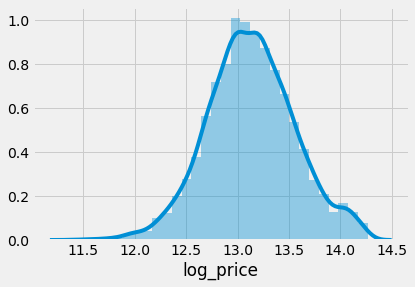

In [55]:
fig, ax = plt.subplots()
# ax.set_xlim([0,2000000])
sns.distplot(df3['log_price'], bins=30)

In [222]:
df3.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'walk_score', 'transit_score', 'pers_crime_score',
       'prop_crime_score', 'income', 'log_price'],
      dtype='object')

In [58]:
X = df3[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'walk_score', 'transit_score',
       'pers_crime_score', 'prop_crime_score', 'income']]

In [59]:
# Creating a new column that makes year_renovated equal to year built if the building has not been renovated.

df3['renovated_2'] = df3['yr_renovated']
df3.loc[df3['yr_renovated']==0, 'renovated_2'] = df3['yr_built']

In [60]:
df3['renovated_yrs_ago'] = 2015 - df3['renovated_2']

In [61]:
# Changing letter grades to numerical values

def make_grade_numerical(x):
    if x=='A':
        return 1
    elif x=='B':
        return 2
    elif x=='C':
        return 3
    elif x=='D':
        return 4
    elif x=='E':
        return 5
    else:
        return x
    

df3['prop_crime_score'] = df3['prop_crime_score'].apply(make_grade_numerical)
df3['pers_crime_score'] = df3['prop_crime_score'].apply(make_grade_numerical)

In [62]:
# Making the crime scores numerical since they were letter grades before
pd.to_numeric(df3['prop_crime_score'], errors='coerce')
pd.to_numeric(df3['pers_crime_score'], errors='coerce')

0        3
1        3
2        3
10       3
11       2
14       2
15       1
17       3
20       3
26       2
27       3
28       2
31       2
32       2
33       2
35       2
37       1
43       2
48       2
52       2
53       2
55       1
63       3
65       2
72       2
77       1
78       3
82       3
85       1
91       1
        ..
21538    2
21539    2
21541    3
21542    2
21543    2
21547    2
21550    4
21552    2
21555    1
21556    2
21557    2
21558    2
21559    1
21567    2
21569    1
21572    4
21574    2
21578    2
21579    2
21582    2
21583    2
21584    2
21586    2
21592    2
21595    2
21604    4
21607    2
21608    3
21610    2
21612    2
Name: pers_crime_score, Length: 5852, dtype: int64

In [227]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 16932 to 2949
Data columns (total 24 columns):
price               500 non-null int64
bedrooms            500 non-null int64
bathrooms           500 non-null float64
sqft_living         500 non-null int64
sqft_lot            500 non-null int64
floors              500 non-null float64
waterfront          500 non-null int64
view                500 non-null int64
condition           500 non-null int64
grade               500 non-null int64
sqft_above          500 non-null int64
sqft_basement       500 non-null int64
yr_built            500 non-null int64
yr_renovated        500 non-null int64
zipcode             500 non-null int64
sqft_living15       500 non-null int64
sqft_lot15          500 non-null int64
walk_score          500 non-null int64
transit_score       500 non-null int64
pers_crime_score    500 non-null int64
prop_crime_score    500 non-null int64
income              500 non-null int64
log_price           500 non-

In [228]:
df3.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'walk_score', 'transit_score', 'pers_crime_score',
       'prop_crime_score', 'income', 'log_price', 'renovated_2'],
      dtype='object')

In [63]:
# Set our X and y in preparation for train/test/split
X = df3[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15', 'walk_score', 'transit_score',
       'pers_crime_score', 'prop_crime_score', 'income',
       'renovated_2']]

y = df3['log_price']

In [65]:
# Export data so I can use this in the next steps
df3.to_csv('FINAL_data.csv')

In [246]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5852 entries, 0 to 21612
Data columns (total 25 columns):
price                5852 non-null int64
bedrooms             5852 non-null int64
bathrooms            5852 non-null float64
sqft_living          5852 non-null int64
sqft_lot             5852 non-null int64
floors               5852 non-null float64
waterfront           5852 non-null int64
view                 5852 non-null int64
condition            5852 non-null int64
grade                5852 non-null int64
sqft_above           5852 non-null int64
sqft_basement        5852 non-null int64
yr_built             5852 non-null int64
yr_renovated         5852 non-null int64
zipcode              5852 non-null int64
sqft_living15        5852 non-null int64
sqft_lot15           5852 non-null int64
walk_score           5852 non-null int64
transit_score        5852 non-null int64
pers_crime_score     5852 non-null int64
prop_crime_score     5852 non-null int64
income               5852 n

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [31]:
lm = LinearRegression()

In [32]:
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
predictions = lm.predict(X_test)

In [148]:
fig = plt.figure(figsize=(10,10)
plt.scatter(y_test, predictions, alpha=0.5)

SyntaxError: invalid syntax (<ipython-input-148-289c0b35139b>, line 2)

In [35]:
y_test.shape

(165,)

In [36]:
predictions.shape

(165,)

In [37]:
from sklearn.cross_validation import cross_val_score

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [38]:
scores = cross_val_score(lm, X, y, cv=10, scoring='r2')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print('Rˆ2 for each cross-val:',scores,'\n')
print('Mean Rˆ2 of all cross vals:',np.mean(scores),'+-',np.std(scores))

Rˆ2 for each cross-val: [0.73563597 0.70324795 0.7210646  0.78394613 0.71448408 0.67603056
 0.83046604 0.76054036 0.60083365 0.72670686] 

Mean Rˆ2 of all cross vals: 0.7252956211238977 +- 0.05864343386084593


In [40]:
degree = 5
est = make_pipeline(PolynomialFeatures(degree), StandardScaler(), 
                    RidgeCV(cv=3,alphas=(1e-14,1e-8,1e-2,100)))


est.fit(X_train, y_train)
print('Train R^2: ',est.score(X_train, y_train))
print('Train SSE:', 
      mean_squared_error(y_train, est.predict(X_train)))
print('Test R^2: ', est.score(X_test, y_test))
print('Test SSE:', 
      mean_squared_error(y_test, est.predict(X_test)))

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.800295e-19
  overwrite_a=False)
/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.250258e-18
  overwrite_a=False)


Train R^2:  0.9331355884244902
Train SSE: 0.012149996557216183
Test R^2:  -8.311856498431329
Test SSE: 1.8944515617697562


Compare the SSE from both the Ridge and RidgeCV

In [ ]:
print('Test SSE RidgeCV:', 
      mean_squared_error(y_test, est.predict(X_test)))
print('Test SSE Ridge:', min(sse_te_Ridge))

Compare the $R^2$ from both the Ridge and RidgeCV

In [ ]:
print('Test R^2 RidgeCV: ', est.score(X_test, y_test))
print('Test R^2 Ridge: ', max(r2_te_Ridge))

# Cross Validation

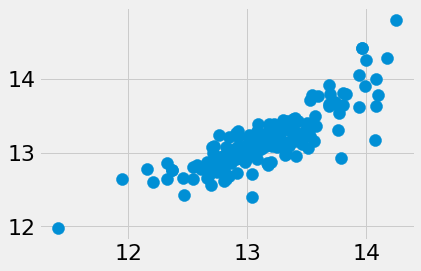

In [247]:
est = make_pipeline(PolynomialFeatures(1), LinearRegression())
est.fit(X_train, y_train)
predictions = est.predict(X_test)
plt.scatter(y_test, predictions)

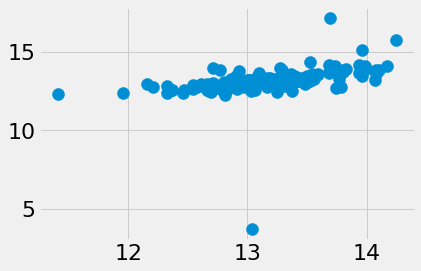

In [248]:
est = make_pipeline(PolynomialFeatures(2), LinearRegression())
est.fit(X_train, y_train)
predictions = est.predict(X_test)
plt.scatter(y_test, predictions)

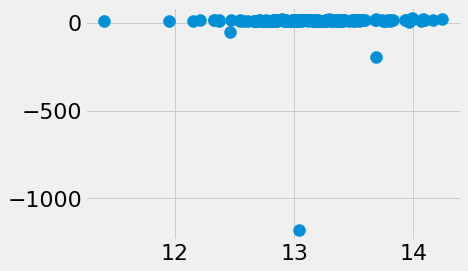

In [249]:
est = make_pipeline(PolynomialFeatures(3), LinearRegression())
est.fit(X_train, y_train)
predictions = est.predict(X_test)
plt.scatter(y_test, predictions)

In [ ]:

# 10-fold cross-validation with our fake data
reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv=10, scoring='r2')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print('Rˆ2 for each cross-val:',scores,'\n')
print('Mean Rˆ2 of all cross vals:',np.mean(scores),'+-',np.std(scores))

In [ ]:
# 10-fold cross-validation with our fake data
reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv=10, scoring='mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print('Mean for each cross-val:',-scores,'\n')
print('Mean of all cross vals:',np.mean(-scores),'+-',np.std(-scores))

In [250]:
reg = LinearRegression()
res_cv = {}
res_train = {}
for degree in range(20):
    
    # transforms the data to polynomials
    poly = PolynomialFeatures(degree)
    X1 = poly.fit_transform(X)
    
    # calculates the MSE for CV
    scores = cross_val_score(reg, X1, y, cv=10, scoring='mean_squared_error') # cross val
    res_cv[degree] = np.mean(-scores)
    
    # calculates the MSE for Training Set
    reg.fit(X1,y)
    y_pred = reg.predict(X1)
    res_train[degree] = np.sum((y_pred-y)**2)/len(y)

KeyboardInterrupt: 

In [ ]:
degrees = list(res_cv.keys())
mse_cv = list(res_cv.values())
mse_train = list(res_train.values())

plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.plot(degrees,mse_cv)
plt.plot(degrees,mse_train)
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.title('Normal Scale')
plt.legend(['CV','Train'])

plt.subplot(1,2,2)
plt.semilogy(degrees,mse_cv)
plt.semilogy(degrees,mse_train)
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.title('Log Scale')

loc = np.argmin(list(res_cv.values()))
print('The degree',degrees[loc],'had an MSE of:',mse_cv[loc])

In [96]:
def create_reg_string(X_df):
    new_str = ''
    for i in range(0, len(X.columns)-1):
        new_str += f' + {X_df.columns[i]}'
    print(new_str)

In [97]:
len(X.columns)

21

In [99]:
create_reg_string(X)

 + bedrooms + bathrooms + sqft_living + sqft_lot + floors + waterfront + view + condition + grade + sqft_above + sqft_basement + yr_built + yr_renovated + sqft_living15 + sqft_lot15 + walk_score + transit_score + pers_crime_score + prop_crime_score + income


In [73]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

In [120]:
df3.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'walk_score', 'transit_score', 'pers_crime_score',
       'prop_crime_score', 'income', 'log_price', 'renovated_2'],
      dtype='object')

In [74]:
create_reg_string(21)

Y ~ X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10 + X11 + X12 + X13 + X14 + X15 + X16 + X17 + X18 + X19 + X20 + X21


In [122]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('log_price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + waterfront + view + condition + grade + sqft_above + sqft_basement + yr_built + yr_renovated + sqft_living15 + sqft_lot15 + walk_score + transit_score + pers_crime_score + prop_crime_score + income + renovated_2', data=df3, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     82.85
Date:                Tue, 09 Oct 2018   Prob (F-statistic):          1.42e-134
Time:                        11:18:30   Log-Likelihood:                 59.920
No. Observations:                 500   AIC:                            -81.84
Df Residuals:                     481   BIC:                            -1.763
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           14.0477      0.893     15.724      0.000      12.292      15.803
bedrooms            -0.0103      0.015     -0.696      0.487      -0.040       0.019
bathrooms           -0.0122      0.020     -0.612      0.541      -0.051       0.027
sqft_living          0.0002   1.73e-05      8.715      0.000       0.000       0.000
sqft_lot         -1.616e-05   6.31e-06     -2.563      0.011   -2.86e-05   -3.77e-06
floors              -0.0657      0.025     -2.590      0.010      -0.116      -0.016
waterfront       -4.998e-11   3.18e-12    -15.722      0.000   -5.62e-11   -4.37e-11
view                 0.0244      0.017      1.397      0.163      -0.010       0.059
condition            0.0681      0.016      4.303      0.000       0.037       0.099
grade                0.1794      0.018     10.070      0.000       0.144       0.214
sqft_above           0.0001   2.18e-05      6.119      0.000    9.07e-05       0.000
sqft_basement     1.712e-05   2.07e-05      0.826      0.409   -2.36e-05    5.78e-05
yr_built             0.0005      0.002      0.231      0.817      -0.004       0.005
yr_renovated       8.65e-05   7.24e-05      1.194      0.233   -5.58e-05       0.000
sqft_living15        0.0002   3.06e-05      5.071      0.000    9.51e-05       0.000
sqft_lot15        6.237e-06   5.49e-06      1.135      0.257   -4.56e-06     1.7e-05
walk_score           0.0053      0.001      6.985      0.000       0.004       0.007
transit_score        0.0003      0.001      0.284      0.777      -0.002       0.003
pers_crime_score    -0.0362      0.007     -5.543      0.000      -0.049      -0.023
prop_crime_score    -0.0362      0.007     -5.543      0.000      -0.049      -0.023
income            2.771e-06   4.97e-07      5.569      0.000    1.79e-06    3.75e-06
renovated_2         -0.0022      0.002     -1.071      0.285      -0.006       0.002
==============================================================================
Omnibus:                       22.765   Durbin-Watson:                   2.214
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.016
Skew:                          -0.115   Prob(JB):                     1.53e-13
Kurtosis:                       4.667   Cond. No.                     7.24e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.15e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [139]:
!mkdir plots/

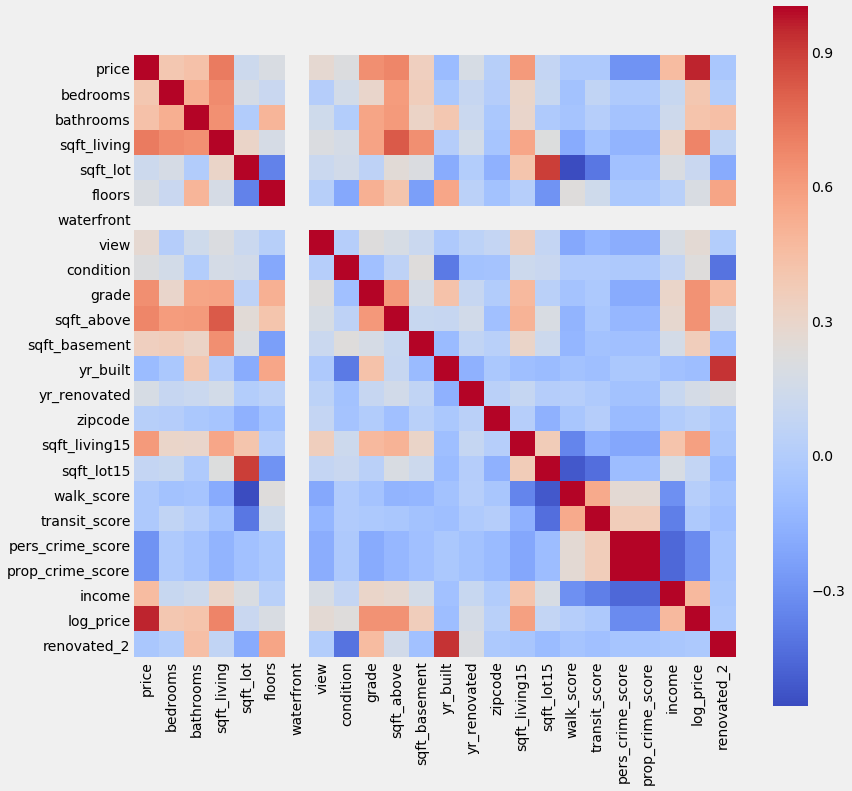

In [142]:
plt.figure(figsize=(12,12))
sns.heatmap(df3.corr(), cmap='coolwarm', square=True)
# fig.savefig('plots/heatmap.jpg')

In [152]:
# Look at most highly correlated values with log_price
df3.corr()['log_price'].sort_values(ascending=False)

log_price           1.000000
price               0.954746
sqft_living         0.686784
grade               0.634588
sqft_above          0.634575
sqft_living15       0.580834
income              0.473139
bathrooms           0.415979
bedrooms            0.399710
sqft_basement       0.353861
view                0.256955
condition           0.228653
floors              0.191583
yr_renovated        0.168611
sqft_lot            0.109419
sqft_lot15          0.073514
zipcode             0.024623
walk_score          0.017569
transit_score      -0.023858
renovated_2        -0.028449
yr_built           -0.094171
pers_crime_score   -0.325992
prop_crime_score   -0.325992
waterfront               NaN
Name: log_price, dtype: float64

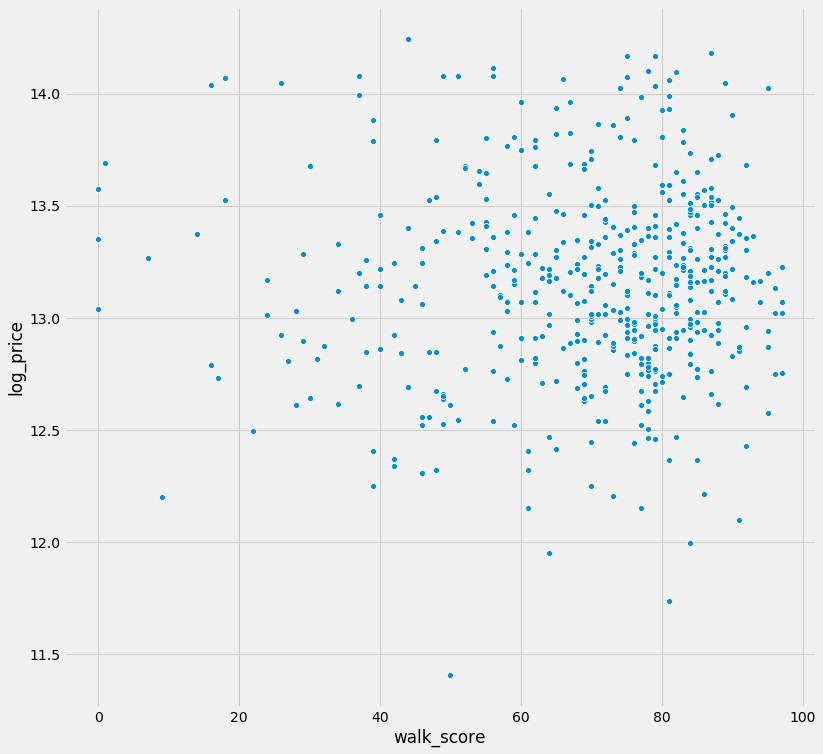

In [161]:
fig = plt.figure(figsize=(12,12))
sns.scatterplot(x='walk_score', y='log_price', data=df3, alpha=1)

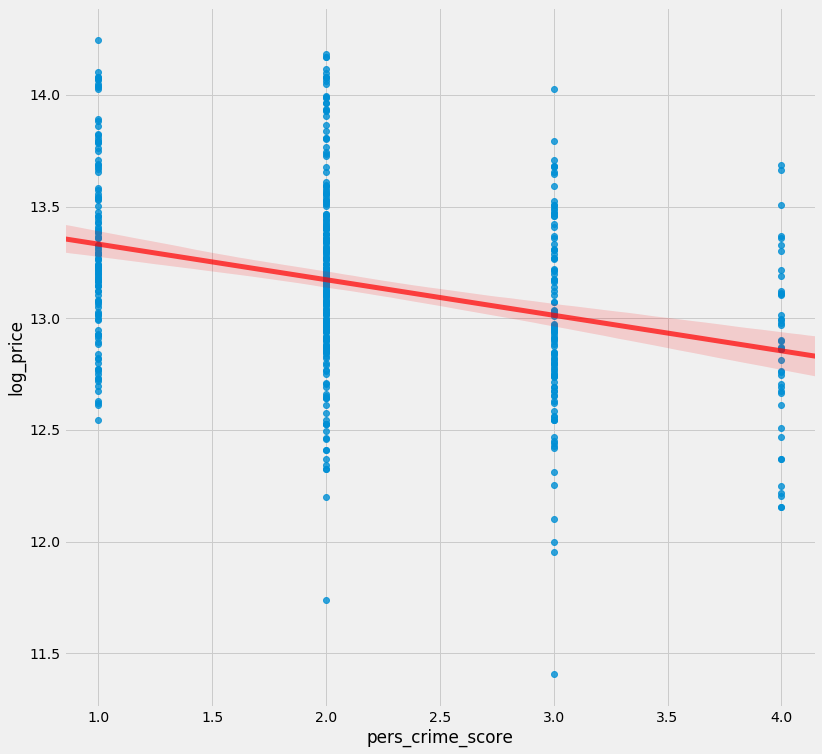

In [169]:
fig = plt.figure(figsize=(12,12))
sns.regplot(x='pers_crime_score', y='log_price', data=df3, line_kws={"color":"r","alpha":0.7,"lw":5})

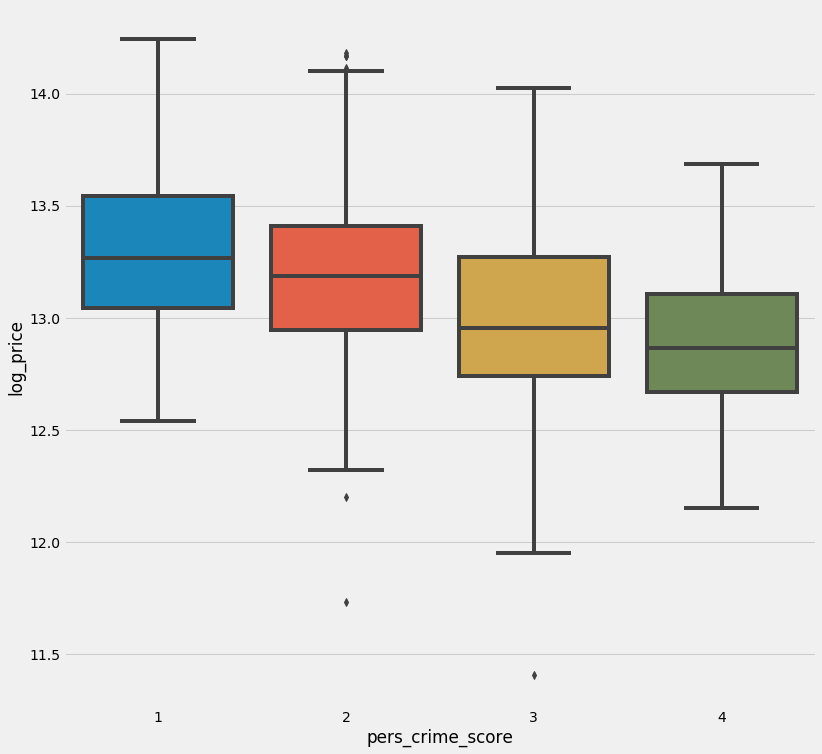

In [174]:
fig = plt.figure(figsize=(12,12))
sns.boxplot(x='pers_crime_score', y='log_price', data=df3)

(12, 14.5)

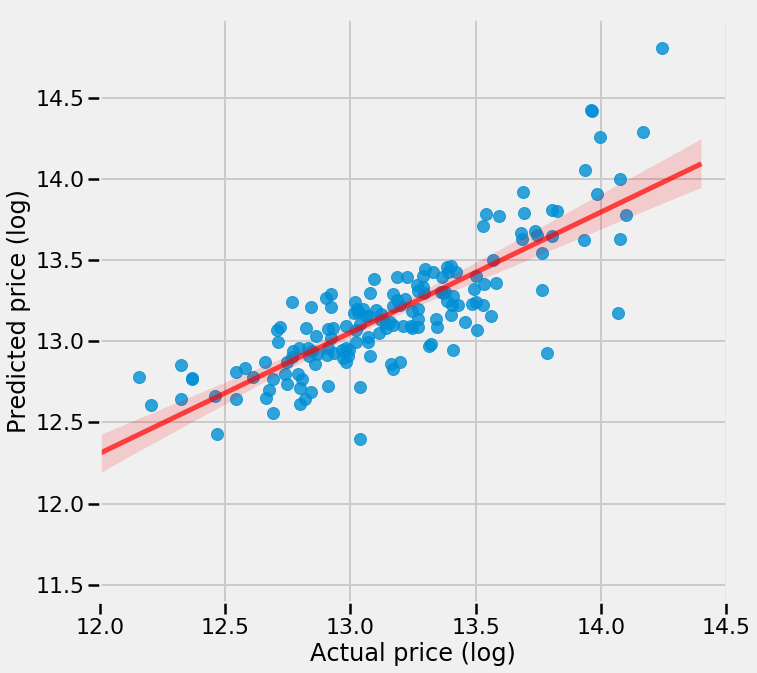

In [201]:
sns.set_context('poster')
# fig = plt.figure(figsize=(12,12))
fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(y_test, predictions, line_kws={"color":"r","alpha":0.7,"lw":5}, ax=ax)
ax.set_xlabel('Actual price (log)')
ax.set_ylabel('Predicted price (log)')
ax.set_xlim(12,14.5)
# plt.tight_layout()
# fig.savefig('plots/regplot.jpg')

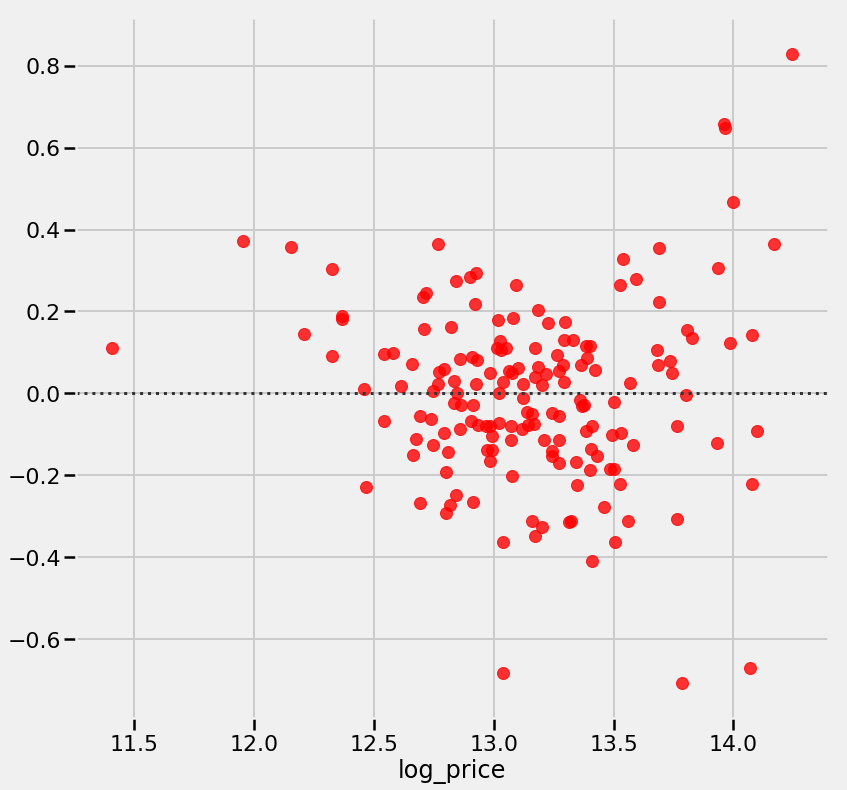

In [199]:
fig = plt.figure(figsize=(12,12))
sns.residplot(y_test, predictions, color='red')
# fig.savefig('plots/residplot.jpg')

In [145]:
print(lr.intercept_)

NameError: name 'lr' is not defined

ValueError: x and y must be the same size

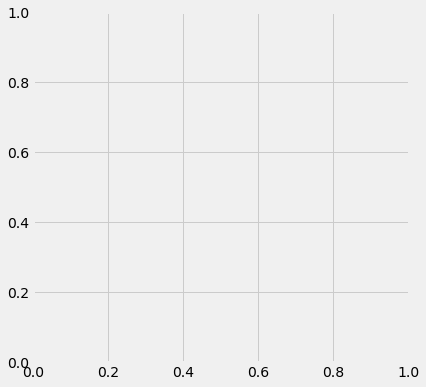

In [147]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error

deg = 10
# Step through degrees from 0 to 15 and store the training and test (generalization) error.
# create array of zeros,
train_error = np.empty(deg)
test_error = np.empty(deg)
plt.figure(figsize=(6,6))
plt.scatter(X_train, y_train,c='b')
plt.scatter(X_test, y_test,c='r')

for degree in range(deg):
    est = make_pipeline(PolynomialFeatures(degree), StandardScaler(), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))
    if degree in np.array([0,1,2,5,15,20]):
        plt.plot(np.linspace(0,np.pi*2,1000).reshape((1000,1)), 
         est.predict(np.linspace(0,np.pi*2,1000).reshape((1000,1))),label=degree)
plt.legend()
plt.ylim((-2, 2));

In [1]:
df3.to_csv('big_dataframe.csv')

NameError: name 'df3' is not defined